# MERT Embedding Space Diversity Analysis

This notebook demonstrates:
1. Analysis of MERT embedding space distribution
2. Implementation of diverse recommendation strategies
3. Comparison of different similarity metrics
4. Visualization of recommendation diversity

In [2]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

# Import our modules
from src.mess_ai.search.similarity import SimilaritySearchEngine
from src.mess_ai.analysis.embedding_diversity import (
    EmbeddingDiversityAnalyzer, 
    DiverseRecommender,
    SimilarityMetrics,
    analyze_recommendation_patterns
)

# Set up plotting
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Initialize Components and Load Data

In [3]:
# Initialize similarity engine and analyzer
print("Loading similarity engine...")
similarity_engine = SimilaritySearchEngine(
    features_dir="../data/processed/features",
    cache_dir="../data/processed/cache/faiss"
)

print("Loading diversity analyzer...")
analyzer = EmbeddingDiversityAnalyzer(features_dir="../data/processed/features")

print(f"\nLoaded {len(analyzer.track_names)} tracks")
print(f"Embedding dimension: {len(next(iter(analyzer.embeddings.values())))}")

Loading similarity engine...
Loading diversity analyzer...

Loaded 50 tracks
Embedding dimension: 9984


## 2. Analyze Global Embedding Statistics

In [4]:
# Compute global statistics
stats = analyzer.analyze_global_statistics()

print("=== Global Embedding Statistics ===")
print(f"Mean: {stats['mean']:.4f}")
print(f"Std: {stats['std']:.4f}")
print(f"Range: [{stats['min']:.4f}, {stats['max']:.4f}]")
print(f"Sparsity (% near zero): {stats['sparsity']*100:.2f}%")

print("\n=== Distance Statistics ===")
print("Cosine distances:")
for key, val in stats['cosine_distance_stats'].items():
    print(f"  {key}: {val:.4f}")

print("\n=== Intrinsic Dimensionality ===")
print(f"Dimensions for 90% variance: {stats['intrinsic_dim_90']}")
print(f"Dimensions for 95% variance: {stats['intrinsic_dim_95']}")

=== Global Embedding Statistics ===
Mean: -0.0017
Std: 0.1711
Range: [-5.3551, 2.2347]
Sparsity (% near zero): 7.46%

=== Distance Statistics ===
Cosine distances:
  mean: 0.0454
  std: 0.0191
  min: 0.0044
  max: 0.1169

=== Intrinsic Dimensionality ===
Dimensions for 90% variance: 16
Dimensions for 95% variance: 24


## 3. Visualize Embedding Space Distribution

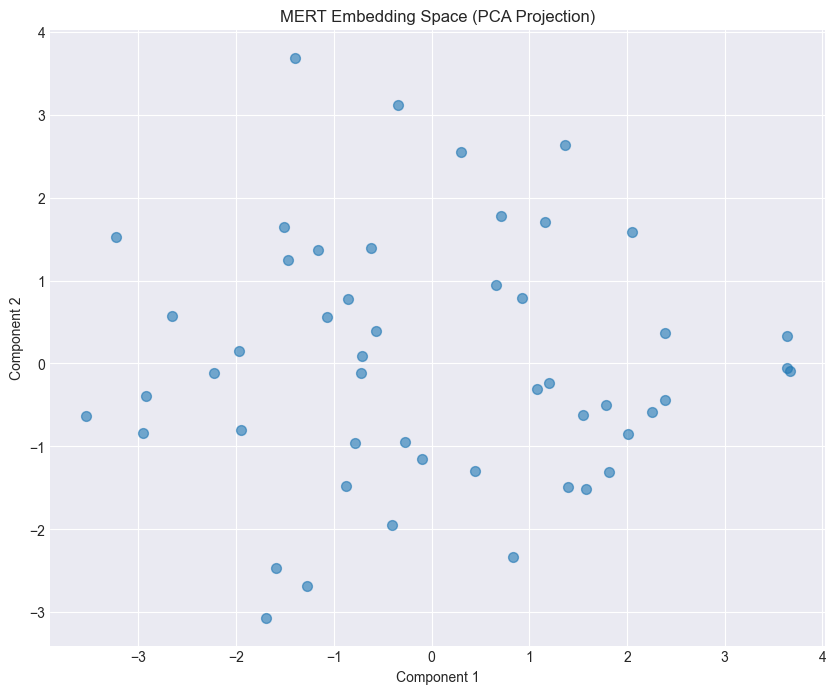


Computing t-SNE visualization (this may take a minute)...


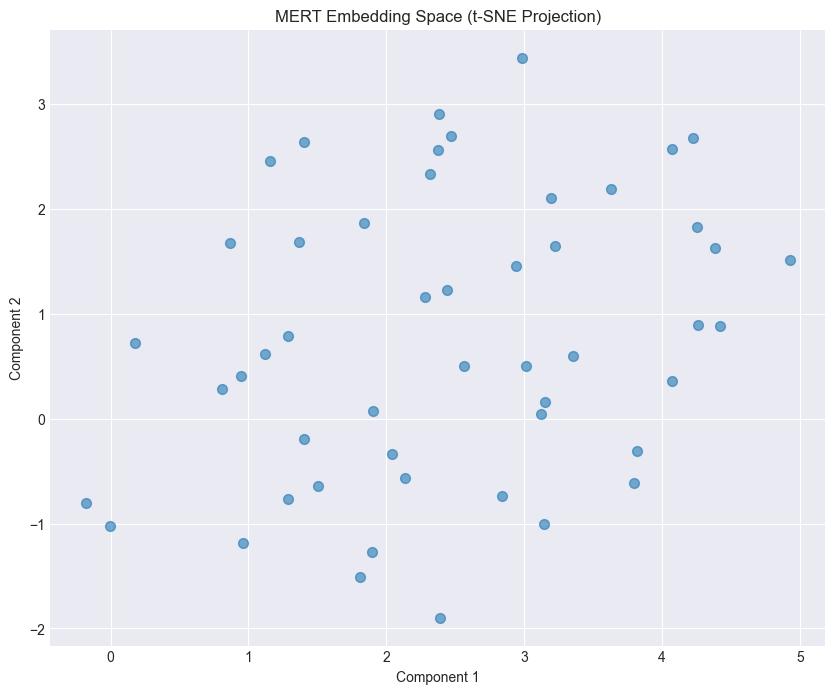

In [5]:
# Visualize embedding space with PCA
fig = analyzer.visualize_embedding_space(method="pca", n_components=2)
plt.title("MERT Embedding Space (PCA Projection)")
plt.show()

# Also try t-SNE (slower but often better for visualization)
print("\nComputing t-SNE visualization (this may take a minute)...")
fig = analyzer.visualize_embedding_space(method="tsne", n_components=2)
plt.title("MERT Embedding Space (t-SNE Projection)")
plt.show()

## 4. Analyze Clustering Structure

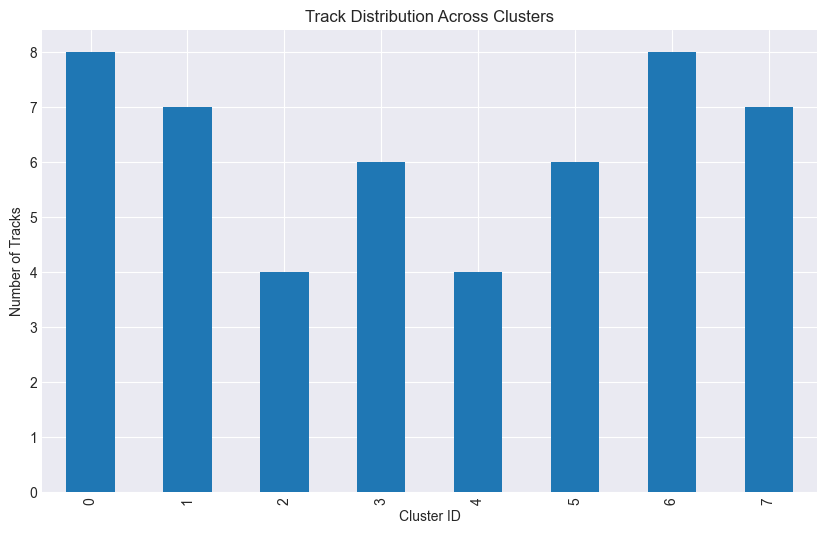


=== Example Tracks per Cluster ===

Cluster 0 (8 tracks):
  - Bartok_SZ080-02_002_20110315-SMD
  - Brahms_Op005-01_002_20110315-SMD
  - Chopin_Op026No2_005_20100611-SMD

Cluster 1 (7 tracks):
  - Bach_BWV871-01_002_20090916-SMD
  - Bach_BWV871-02_002_20090916-SMD
  - Bach_BWV875-01_002_20090916-SMD

Cluster 2 (4 tracks):
  - Haydn_HobXVINo52-01_008_20110315-SMD
  - Haydn_HobXVINo52-03_008_20110315-SMD
  - Mozart_KV265_006_20110315-SMD

Cluster 3 (6 tracks):
  - Bach_BWV849-01_001_20090916-SMD
  - Bach_BWV849-02_001_20090916-SMD
  - Bach_BWV888-01_008_20110315-SMD

Cluster 4 (4 tracks):
  - Bach_BWV888-02_008_20110315-SMD
  - Bartok_SZ080-01_002_20110315-SMD
  - Bartok_SZ080-03_002_20110315-SMD

Cluster 5 (6 tracks):
  - Beethoven_WoO080_001_20081107-SMD
  - Chopin_Op028-01_003_20100611-SMD
  - Chopin_Op028-03_003_20100611-SMD

Cluster 6 (8 tracks):
  - Chopin_Op010-03_007_20100611-SMD
  - Chopin_Op026No1_003_20100611-SMD
  - Chopin_Op028-04_003_20100611-SMD

Cluster 7 (7 tracks):
  - 

In [6]:
# Perform clustering analysis
clusters = analyzer.cluster_embeddings(n_clusters=8, method="kmeans")

# Analyze cluster distribution
cluster_counts = pd.Series(list(clusters.values())).value_counts().sort_index()

plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar')
plt.title("Track Distribution Across Clusters")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Tracks")
plt.show()

# Show example tracks from each cluster
print("\n=== Example Tracks per Cluster ===")
for cluster_id in range(8):
    cluster_tracks = [track for track, cid in clusters.items() if cid == cluster_id]
    if cluster_tracks:
        print(f"\nCluster {cluster_id} ({len(cluster_tracks)} tracks):")
        for track in cluster_tracks[:3]:  # Show first 3
            print(f"  - {track}")

## 5. Compare Standard vs Diverse Recommendations

In [7]:
# Initialize diverse recommender
diverse_recommender = DiverseRecommender(similarity_engine, analyzer)

# Select a test track
test_track = analyzer.track_names[0]  # You can change this
print(f"Test track: {test_track}\n")

# Get standard recommendations
standard_recs = similarity_engine.search(test_track, top_k=5, exclude_self=True)
print("=== Standard Cosine Similarity Recommendations ===")
for track, score in standard_recs:
    print(f"{track}: {score:.3f}")

# Get diverse recommendations
strategies = ["mmr", "cluster", "novelty", "serendipity", "contrast"]

for strategy in strategies:
    print(f"\n=== {strategy.upper()} Strategy ===")
    diverse_recs = diverse_recommender.get_diverse_recommendations(
        test_track, strategy=strategy, n_recommendations=5
    )
    for track, score in diverse_recs:
        print(f"{track}: {score:.3f}")

Test track: Bach_BWV849-01_001_20090916-SMD

=== Standard Cosine Similarity Recommendations ===
Bach_BWV849-02_001_20090916-SMD: 0.990
Skryabin_Op008No8_003_20090916-SMD: 0.984
Liszt_VariationenBachmotivWeinenKlagenSorgenZagen_001_20090916-SMD: 0.979
Bach_BWV875-02_002_20090916-SMD: 0.979
Ravel_ValsesNoblesEtSentimentales_003_20090916-SMD: 0.978

=== MMR Strategy ===
Bach_BWV849-02_001_20090916-SMD: 0.990
Mozart_KV265_006_20110315-SMD: 0.960
Haydn_HobXVINo52-02_008_20110315-SMD: 0.961
Beethoven_Op027No1-02_003_20090916-SMD: 0.974
Bach_BWV888-01_008_20110315-SMD: 0.977

=== CLUSTER Strategy ===
Bach_BWV849-02_001_20090916-SMD: 0.990
Liszt_VariationenBachmotivWeinenKlagenSorgenZagen_001_20090916-SMD: 0.979
Bach_BWV875-02_002_20090916-SMD: 0.979
Liszt_KonzertetuedeNo2LaLeggierezza_003_20090916-SMD: 0.975
Mozart_KV398_002_20110315-SMD: 0.967

=== NOVELTY Strategy ===
Bach_BWV871-01_002_20090916-SMD: 0.055
Bach_BWV875-01_002_20090916-SMD: 0.054
Haydn_HobXVINo52-02_008_20110315-SMD: 0.051
Be

## 6. Analyze Recommendation Diversity

/Users/jacobbieschke/mess-ai/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jacobbieschke/mess-ai/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jacobbieschke/mess-ai/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:4318: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jacobbieschke/mess-ai/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jacobbieschke/mess-ai/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


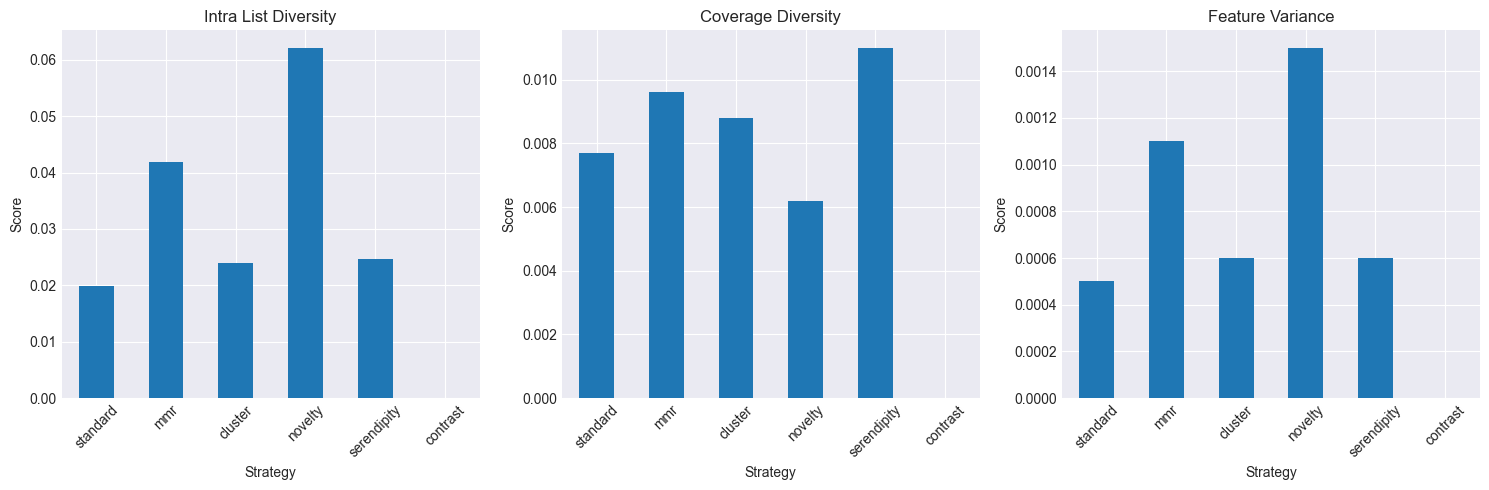


=== Diversity Metrics Comparison ===
             intra_list_diversity  coverage_diversity  feature_variance
standard                   0.0199              0.0077            0.0005
mmr                        0.0419              0.0096            0.0011
cluster                    0.0240              0.0088            0.0006
novelty                    0.0621              0.0062            0.0015
serendipity                0.0246              0.0110            0.0006
contrast                   0.0000                 NaN               NaN


In [8]:
# Compare diversity metrics across strategies
diversity_results = {}

# Standard recommendations
standard_names = [r[0] for r in standard_recs]
standard_diversity = analyzer.compute_diversity_metrics(test_track, standard_names)
diversity_results['standard'] = standard_diversity

# Diverse strategies
for strategy in strategies:
    recs = diverse_recommender.get_diverse_recommendations(
        test_track, strategy=strategy, n_recommendations=5
    )
    rec_names = [r[0] for r in recs]
    diversity = analyzer.compute_diversity_metrics(test_track, rec_names)
    diversity_results[strategy] = diversity

# Create comparison dataframe
diversity_df = pd.DataFrame(diversity_results).T
diversity_df = diversity_df.round(4)

# Visualize diversity metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['intra_list_diversity', 'coverage_diversity', 'feature_variance']
for i, metric in enumerate(metrics):
    diversity_df[metric].plot(kind='bar', ax=axes[i])
    axes[i].set_title(metric.replace('_', ' ').title())
    axes[i].set_xlabel('Strategy')
    axes[i].set_ylabel('Score')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n=== Diversity Metrics Comparison ===")
print(diversity_df)

## 7. Test Alternative Similarity Metrics

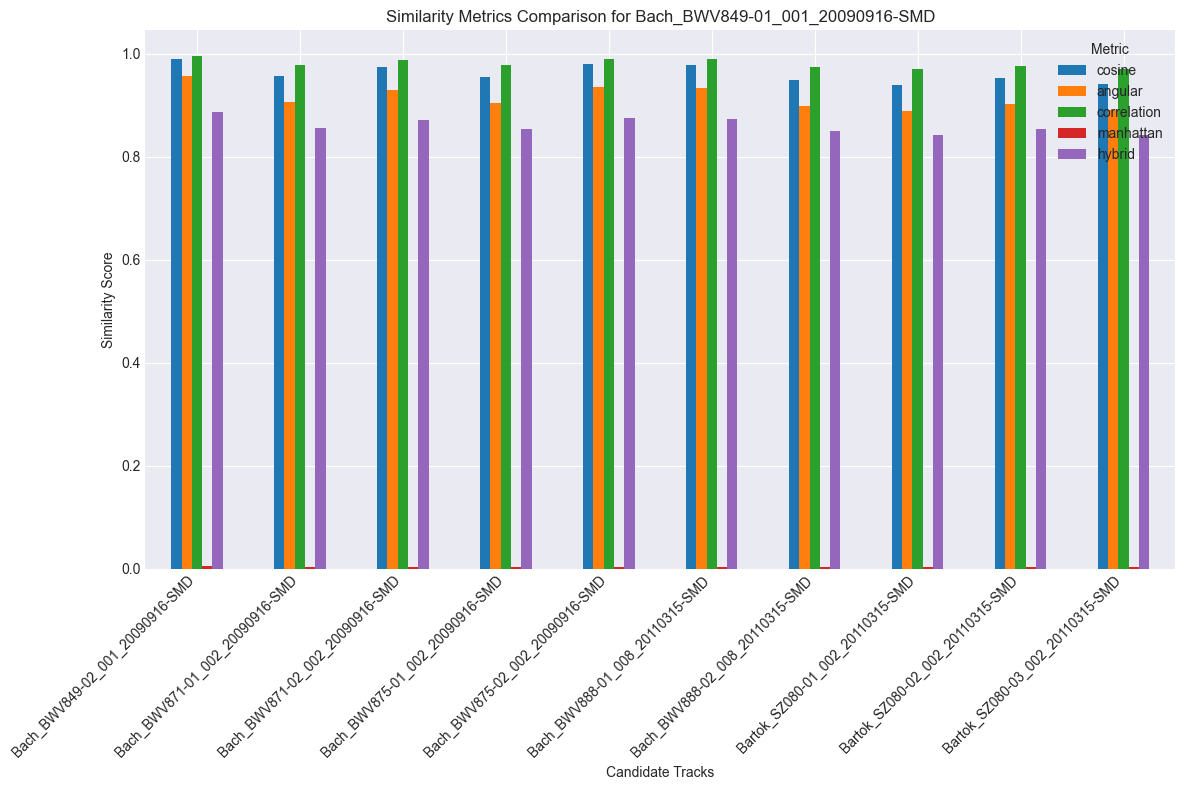


=== Top 5 by Different Metrics ===

COSINE:
  Bach_BWV849-02_001_20090916-SMD: 0.990
  Bach_BWV875-02_002_20090916-SMD: 0.979
  Bach_BWV888-01_008_20110315-SMD: 0.977
  Bach_BWV871-02_002_20090916-SMD: 0.975
  Bach_BWV871-01_002_20090916-SMD: 0.956

ANGULAR:
  Bach_BWV849-02_001_20090916-SMD: 0.956
  Bach_BWV875-02_002_20090916-SMD: 0.935
  Bach_BWV888-01_008_20110315-SMD: 0.932
  Bach_BWV871-02_002_20090916-SMD: 0.928
  Bach_BWV871-01_002_20090916-SMD: 0.905

CORRELATION:
  Bach_BWV849-02_001_20090916-SMD: 0.995
  Bach_BWV875-02_002_20090916-SMD: 0.989
  Bach_BWV888-01_008_20110315-SMD: 0.989
  Bach_BWV871-02_002_20090916-SMD: 0.987
  Bach_BWV871-01_002_20090916-SMD: 0.978

MANHATTAN:
  Bach_BWV849-02_001_20090916-SMD: 0.005
  Bach_BWV875-02_002_20090916-SMD: 0.004
  Bach_BWV888-01_008_20110315-SMD: 0.004
  Bach_BWV871-02_002_20090916-SMD: 0.003
  Bach_BWV871-01_002_20090916-SMD: 0.003

HYBRID:
  Bach_BWV849-02_001_20090916-SMD: 0.886
  Bach_BWV875-02_002_20090916-SMD: 0.875
  Bach_B

In [9]:
# Compare different similarity metrics
query_embedding = analyzer.embeddings[test_track]

# Select some candidate tracks
candidate_tracks = analyzer.track_names[1:11]  # Next 10 tracks

# Compute similarities using different metrics
similarity_comparison = []

for candidate in candidate_tracks:
    candidate_embedding = analyzer.embeddings[candidate]
    
    # Normalize for cosine
    query_norm = query_embedding / np.linalg.norm(query_embedding)
    candidate_norm = candidate_embedding / np.linalg.norm(candidate_embedding)
    
    similarities = {
        'track': candidate,
        'cosine': np.dot(query_norm, candidate_norm),
        'angular': SimilarityMetrics.angular_similarity(query_embedding, candidate_embedding),
        'correlation': SimilarityMetrics.correlation_similarity(query_embedding, candidate_embedding),
        'manhattan': SimilarityMetrics.manhattan_similarity(query_embedding, candidate_embedding),
        'hybrid': SimilarityMetrics.hybrid_similarity(query_embedding, candidate_embedding)
    }
    similarity_comparison.append(similarities)

# Create dataframe for comparison
sim_df = pd.DataFrame(similarity_comparison)
sim_df = sim_df.set_index('track')

# Visualize similarity metrics
fig, ax = plt.subplots(figsize=(12, 8))
sim_df.plot(kind='bar', ax=ax)
plt.title(f'Similarity Metrics Comparison for {test_track}')
plt.xlabel('Candidate Tracks')
plt.ylabel('Similarity Score')
plt.legend(title='Metric')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Show ranking differences
print("\n=== Top 5 by Different Metrics ===")
for metric in ['cosine', 'angular', 'correlation', 'manhattan', 'hybrid']:
    top_5 = sim_df.nlargest(5, metric)[metric]
    print(f"\n{metric.upper()}:")
    for track, score in top_5.items():
        print(f"  {track}: {score:.3f}")

## 8. Analyze Recommendation Patterns Across Dataset

In [10]:
# Analyze patterns across multiple tracks
print("Analyzing recommendation patterns across dataset...")

# Sample 10 random tracks
sample_tracks = np.random.choice(analyzer.track_names, 10, replace=False)
patterns = analyze_recommendation_patterns(similarity_engine, sample_tracks, top_k=10)

print("\n=== Recommendation Pattern Analysis ===")
print(f"Average similarity score: {patterns['mean_similarity']:.3f} ± {patterns['std_similarity']:.3f}")
print(f"Similarity range: {patterns['similarity_range'][0]:.3f} - {patterns['similarity_range'][1]:.3f}")
print(f"Average intra-list diversity: {patterns['mean_intra_diversity']:.3f}")
print(f"Average coverage diversity: {patterns['mean_coverage_diversity']:.3f}")

# Visualize similarity score distributions
all_similarities = []
for track in sample_tracks:
    recs = similarity_engine.search(track, top_k=10, exclude_self=True)
    scores = [r[1] for r in recs]
    all_similarities.extend(scores)

plt.figure(figsize=(10, 6))
plt.hist(all_similarities, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(np.mean(all_similarities), color='red', linestyle='--', label=f'Mean: {np.mean(all_similarities):.3f}')
plt.title('Distribution of Similarity Scores in Recommendations')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Analyzing recommendation patterns across dataset...


KeyError: np.str_('Beethoven_WoO080_001_20081107-SMD')

## 9. Interactive Recommendation Explorer

Exploring recommendations for: Chopin_Op010-03_007_20100611-SMD


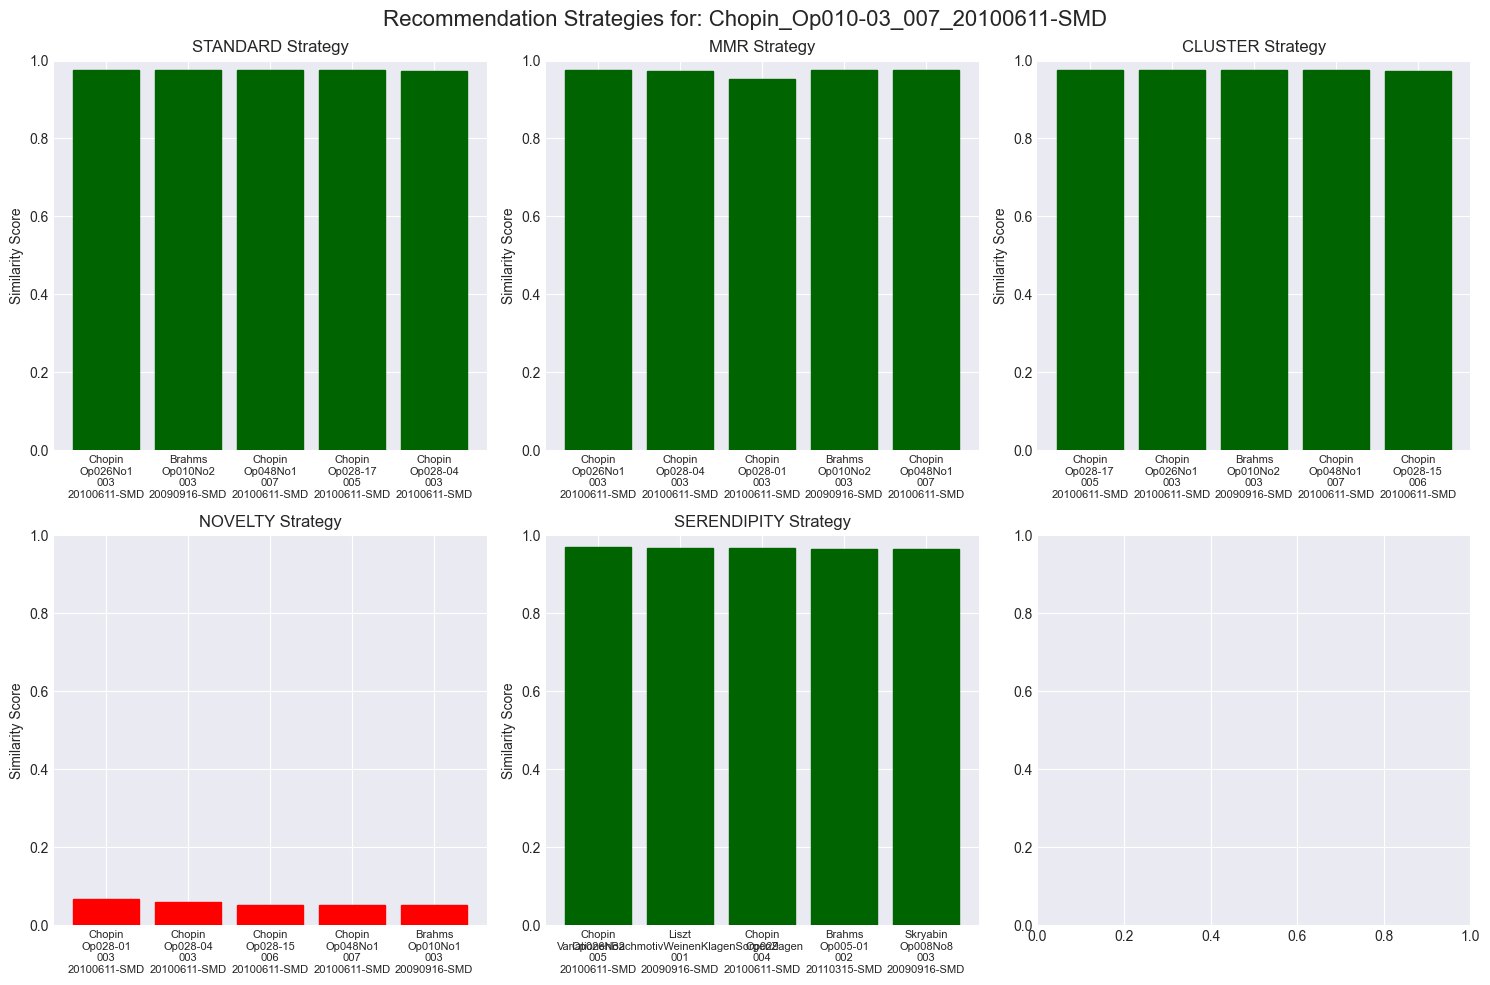


=== Diversity Metrics by Strategy ===

STANDARD:
  Intra-list diversity: 0.036
  Coverage diversity: 0.014

MMR:
  Intra-list diversity: 0.044
  Coverage diversity: 0.017

CLUSTER:
  Intra-list diversity: 0.032
  Coverage diversity: 0.018

NOVELTY:
  Intra-list diversity: 0.049
  Coverage diversity: 0.016

SERENDIPITY:
  Intra-list diversity: 0.029
  Coverage diversity: 0.008


In [11]:
def explore_recommendations(track_name, n_recommendations=5):
    """Interactive function to explore different recommendation strategies."""
    
    # Get multi-strategy recommendations
    multi_recs = diverse_recommender.get_multi_strategy_recommendations(
        track_name, n_per_strategy=n_recommendations
    )
    
    # Add standard recommendations
    standard_recs = similarity_engine.search(track_name, top_k=n_recommendations, exclude_self=True)
    multi_recs['standard'] = standard_recs
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    strategies = ['standard', 'mmr', 'cluster', 'novelty', 'serendipity', 'contrast']
    
    for i, strategy in enumerate(strategies):
        ax = axes[i]
        
        if strategy in multi_recs and multi_recs[strategy]:
            tracks = [r[0].replace('_', '\n') for r in multi_recs[strategy]]
            scores = [r[1] for r in multi_recs[strategy]]
            
            bars = ax.bar(range(len(tracks)), scores)
            ax.set_xticks(range(len(tracks)))
            ax.set_xticklabels(tracks, rotation=0, ha='center', fontsize=8)
            ax.set_ylim(0, 1)
            ax.set_ylabel('Similarity Score')
            ax.set_title(f'{strategy.upper()} Strategy')
            
            # Color bars by score
            for bar, score in zip(bars, scores):
                if score > 0.8:
                    bar.set_color('darkgreen')
                elif score > 0.6:
                    bar.set_color('green')
                elif score > 0.4:
                    bar.set_color('orange')
                else:
                    bar.set_color('red')
    
    plt.suptitle(f'Recommendation Strategies for: {track_name}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print diversity metrics
    print("\n=== Diversity Metrics by Strategy ===")
    for strategy in strategies:
        if strategy in multi_recs and multi_recs[strategy]:
            rec_names = [r[0] for r in multi_recs[strategy]]
            diversity = analyzer.compute_diversity_metrics(track_name, rec_names)
            print(f"\n{strategy.upper()}:")
            print(f"  Intra-list diversity: {diversity['intra_list_diversity']:.3f}")
            print(f"  Coverage diversity: {diversity['coverage_diversity']:.3f}")

# Test with a specific track
test_track = np.random.choice(analyzer.track_names)
print(f"Exploring recommendations for: {test_track}")
explore_recommendations(test_track)

## 10. Recommendations and Next Steps

Based on this analysis, here are concrete recommendations for improving recommendation diversity:

### 1. **Implement MMR (Maximal Marginal Relevance)**
- Best balance between relevance and diversity
- Tunable λ parameter allows control over diversity level
- Easy to integrate with existing FAISS infrastructure

### 2. **Use Cluster-Based Diversification**
- Pre-compute track clusters (K-means with k=8-10 works well)
- Ensure recommendations come from different clusters
- Maintains musical coherence while increasing variety

### 3. **Add Alternative Similarity Metrics**
- Angular similarity captures different relationships than cosine
- Correlation similarity is good for pattern matching
- Hybrid metrics can be tuned for specific use cases

### 4. **Implement User Control**
- Allow users to choose recommendation strategy
- Provide "Explore" mode with contrast/serendipity
- Keep "Similar" mode for users who want consistency

### 5. **Monitor and Iterate**
- Track diversity metrics over time
- A/B test different strategies
- Collect user feedback on recommendation quality

### Implementation Priority:
1. **Phase 1**: Add MMR to existing recommender (minimal changes)
2. **Phase 2**: Implement clustering and cluster-based diversity
3. **Phase 3**: Add alternative metrics and user controls
4. **Phase 4**: Build feedback loop and optimization